# Program to read Wave HVA file'
### JW 12/18-01/19

In [1]:
import array as arr
import binascii
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy as sp
import statistics as s
import sys

from datetime import datetime, time, timedelta
from itertools import count # izip for maximum efficiency
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path, PureWindowsPath
from scipy import fftpack, signal
from scipy.signal import tukey
from statistics import mean
from tkinter import filedialog
from tkinter import *

In [2]:
def get_file():
    """Get an input file

    This module uses tkinter routines to provide graphical display of files,
    allowing user to select an input file for the program.

    Args:
        root.filename (str): Name of input data file to be read.
        
    Returns:
        root.filename (str): Input data file to be read.
        
    JW November 2019
    """    

# Select input file
    root = Tk()
    root.filename = filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data",\
    title = "Select HVA file",filetypes = (("HVA files","*.hva"),("all files","*.*"))) 

    root.destroy()
    
    return(root.filename)

In [3]:
def Do_CRC(packet):
# Do CRC-4 checksum calculation
# See DWTP 2.1.1 pp25-26.
    key_table = [0,3,6,5,12,15,10,9,11,8,13,14,7,4,1,2]; crc = 0
    for i in range(len(packet)):
        crc = key_table[(crc^(int(packet[i][0],16))) & int('0x0f',16)]        # First nibble
        if (i > 0): 
            crc = key_table[(crc^int(packet[i][1],16)) & int('0x0f',16)]      # Second nibble

    crc = (crc^int(packet[0][1],16)) & int('0x0f',16)
    if (crc != 0): 
        print('CRC Error!',crc)
    return   # Do_CRC()

In [4]:
def Displacement(valu):
# Decode real time data to Displacements_List in metres
# See DWTP 2.1.1 p20. Formula 16
    return (0.457*math.sinh(valu/457.))

In [5]:
def Do_Timestamp(packet):
# Decode SST message vide DWTP p. 27
    Do_CRC(packet)
    Datawell_start_time = datetime(1970,1,1)
    i = int(packet[2]+packet[3]+packet[4]+packet[5],16)
    if i == 2**32-1:                   # Check for NaN
        print("Timestamp = NaN")
        Record_time = datetime.date.min
    else:
        Record_time = Datawell_start_time + timedelta(seconds=i) 
##        + timedelta(hours=10)  # Corrected from UTC to Aus EST  <<<<< STILL SOME CONFUSION ABOUT THIS
    return (Record_time)

In [6]:
def twos_complement(value, bitWidth):
    if value >= 2**bitWidth:
        # This catches value that is out of range
        raise ValueError("Value: {} out of range of {}-bit value.".format(value, bitWidth))
    else:
        return value - int((value << 1) & 2**bitWidth)

In [7]:
def Do_F20(packet):
# Decode Heave spectrum message vide DWTP p. 38-40
    Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    No_of_segments = int(packet[8],16)
    if No_of_segments == 255:                   # Check for NaN
        print("Number of segments = NaN")
    Smax = int(packet[9]+packet[10][0],16)
    if Smax == 4095:                   # Check for NaN
        print("Smax = NaN"); Smax = -99.99
    else:
        Smax = 5000*(math.exp(Smax/200.) - 1) / (math.exp(4094/200.) - 1)
    s_tilde = []
    for i in range(0,148,3):
        u = int(packet[11+i]+packet[12+i][0],16)
        s_tilde.append(Smax*(math.exp(u/200.) - 1) / (math.exp(4094/200.) - 1))
        u = int(packet[12+i][1]+packet[13+i],16)
        s_tilde.append(Smax*(math.exp(u/200.) - 1) / (math.exp(4094/200.) - 1))
##        print('{:18s}{:%Y-%m-%d %H:%M}{:6s}'.format('Heave spectrum at ',Record_time,' AEST:'))
##        print('{:27s}{:10.4f}{:2s}{:1s}{:3s}'.format('Peak value of PSD (Smax) = ',Smax,' m',chr(178),'/Hz'))
    
    return (Record_time,s_tilde,Smax)

In [8]:
def Do_F23(packet):
# Decode Spectrum synchronisation message vide DWTP p. 45-47
##    print('In Spectrum synchronisation routine')
    Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    Segments_used = '0000000'+packet[8][:-1]+packet[9]+packet[10]
    Sample_number = int(packet[11]+packet[12],16)
            
    Hn_1 = packet[13]+packet[14][0]; Nn_1 = packet[14][1]+packet[15]; Wn_1 = packet[16]+packet[17][0]
    Hn = packet[17][1]+packet[18]; Nn = packet[19]+packet[20][0]; Wn = packet[20][1]+packet[21]
    
    Match_vector = Hn_1+Nn_1+Wn_1+Hn+Nn+Wn  # build a HEX string to be matched with WLS list

    Hn_1_sign = Displacement(twos_complement(int(Hn_1,16),12))        # Uses formula 16 from DWTP p. 20
    Nn_1_sign = Displacement(twos_complement(int(Nn_1,16),12))
    Wn_1_sign = Displacement(twos_complement(int(Wn_1,16),12))

    Hn_sign = Displacement(twos_complement(int(Hn,16),12))
    Nn_sign = Displacement(twos_complement(int(Nn,16),12))
    Wn_sign = Displacement(twos_complement(int(Wn,16),12))
    
    if Sample_number == 65536:                   # Check for NaN
        print("Timestamp = NaN")
    
    return (Record_time,Match_vector,Sample_number,Hn_1_sign,Nn_1_sign,Wn_1_sign,Hn_sign,Nn_sign,Wn_sign)

In [9]:
def Do_F25(packet):
# Decode Directional Spectral Parameters message vide DWTP p. 51-53
    Do_CRC(packet)
    Record_time = Do_Timestamp(packet)
    Data_stamp = packet[6]+packet[7]
    No_of_segments = int(packet[8],16)
    if No_of_segments == 255:                   # Check for NaN
        print("Number of segments = NaN")
    Hs = int(packet[9]+packet[10][0],16)
    Ti = int(packet[10][1]+packet[11],16)
    Te = int(packet[12]+packet[13][0],16)
    T1 = int(packet[13][1]+packet[14],16)
    Tz = int(packet[15]+packet[16][0],16)
    T3 = int(packet[16][1]+packet[17],16)
    Tc = int(packet[18]+packet[19][0],16)
    Rp = int(packet[19][1]+packet[20],16)
    Tp = int(packet[21]+packet[22][0],16)
    Smax = int(packet[22][1]+packet[23],16)
    Theta_p = int(packet[24]+packet[25][0],16)
    Sigma_p = int(packet[25][1]+packet[26],16)
    
# Check for NaN    
    if Hs == 4095: print("Hs = NaN") 
    else: Hs = Hs/100.
    if Ti == 4095: print("Ti = NaN") 
    else: Ti = Ti/100.
    if Te == 4095: print("Te = NaN") 
    else: Te = Te/100.        
    if T1 == 4095: print("T1 = NaN") 
    else: T1 = T1/100.
    if Tz == 4095: print("Tz = NaN") 
    else: Tz = Tz/100.
    if T3 == 4095: print("T3 = NaN") 
    else: T3 = T3/100.
    if Tc == 4095: print("Tc = NaN") 
    else: Tc = Tc/100.
    if Rp == 4095: print("Rp = NaN")                 # See note with p.50 Formula 65 re Goda's peakedness
    else: Rp = Rp/4094.
    if Tp == 4095: print("Tp = NaN") 
    else: Tp = Tp/100.
    if Smax == 4095: print("Smax = NaN") 
    else: Smax = 5000*(math.exp(Smax/200.) - 1) / (math.exp(4094/200.) - 1)
    if Theta_p == 4095: print("Theta_p = NaN") 
    else: Theta_p = math.degrees(Theta_p/4095.*2.*math.pi)    # Note - Theta_p converted to Degrees!!!
    if Sigma_p == 4095: print("Sigma_p = NaN") 
    else: Sigma_p = math.degrees(Sigma_p/4095.*math.pi/2.)    # Note - Sigma_p converted to Degrees!!!
    
##    print('{:%Y-%m-%d %H:%M}{:11s}{:5.2f}{:6s}{:5.2f}{:6s}{:5.2f}{:6s}{:5.2f}{:6s}{:5.2f}{:6s}{:5.2f}{:6s}{:5.2f}' \
##        .format(Record_time,' AEST Hs = ',Hs,' Ti = ',Ti,' Te = ',Te,' T1 = ',T1,' Tz = ',Tz,' T3 = ',T3,' Tc = ',Tc))
##    print('{:>27s}{:5.2f}{:6s}{:5.2f}{:8s}{:5.4f}{:11s}{:5.4f}{:1s}{:11s}{:5.4f}{:1s}' \
##        .format(' Rp = ',Rp,' Tp = ',Tp,' Smax = ',Smax,' Theta_p = ',Theta_p,chr(176),' Sigma_p = ',Sigma_p,chr(176)))
    return ()

In [10]:
def Get_Displacements(Position, Sample_number,Status, Displacements_List, wls, north, west):    
    Step_back = int(Sample_number / 2)
    n = Position[0] - Step_back + 1
    for m in range(Step_back):
 
#######################################
# Read displacement data and convert to actual values
# Refer to DWTP pp.19-21 AND Datawell Waverider RX-C4 Receiver Manual p.38
#######################################
        line_number = Cycle_counter[m]
        displacement_record = Displacements_List[n+m]
        status_byte = displacement_record[0:1]
        Status.append(status_byte)
        record_0 = displacement_record[1:3]
        record_1 = displacement_record[3:5]
        record_2 = displacement_record[5:7]
        record_3 = displacement_record[7:9]
        record_4 = displacement_record[9:11]
        record_5 = displacement_record[11:13]
        record_6 = displacement_record[13:15]
        record_7 = displacement_record[15:17]
        record_8 = displacement_record[17:19]
        
# Build the 12 bit HEX value from the 8 bit records 0 to 8        
        h0 = record_0+record_1[0]; n0 = record_1[1]+record_2; w0 = record_3+record_4[0]
        h1 = record_4[1]+ record_5; n1 = record_6+record_7[0]; w1= record_7[1]+record_8
        
### Need to include check for NAN here !!!

# Convert the 12 bit HEX value into a signed integer, and then into actual displacement value
        h0_sign = Displacement(twos_complement(int(h0,16),12))
        n0_sign = Displacement(twos_complement(int(n0,16),12))
        w0_sign = Displacement(twos_complement(int(w0,16),12))
        h1_sign = Displacement(twos_complement(int(h1,16),12))
        n1_sign = Displacement(twos_complement(int(n1,16),12))
        w1_sign = Displacement(twos_complement(int(w1,16),12))
        
# Build lists holding each of the displacement values
        wls.append(h0_sign); wls.append(h1_sign) 
        north.append(n0_sign); north.append(n1_sign)
        west.append(w0_sign); west.append(w1_sign)

    return(Status,wls,north,west)

In [11]:
def calc_frequencies():
    fk = []
    for k in range(100):
        if k<46: fk.append(0.025 + 0.005*k)
        if k>=46 and k<79: fk.append(-0.20 + 0.010*k)
        if k>=79: fk.append(-0.98 + 0.020*k)
    return(fk)        

In [12]:
def print_spectra(fk,s_tidle,dirn,spread):
    print('{:36s}'.format('Freq.    Heave       Dirn.    Spread'))
    for k in range(100):
        print('{:>02.3f}{:3s}{:>05.6f}{:3s}{:>05.4f}{:3s}{:>05.4f}'.format(fk[k],'   ',s_tidle[k],'   ',dirn[k],'   ',spread[k]))
    return()

In [13]:
def calc_spectral_parameters(wls):
    Sample_frequency = 2.56                 # vide Datawell Library Manual P.40
    f_avg = []; Pden_avg = []; f_Mk4 = []
    for i in range(0,46,1): f_Mk4.append(0.025+0.005*i)
    for i in range(46,79,1): f_Mk4.append(-0.20+0.010*i)
    for i in range(79,100,1): f_Mk4.append(-0.98+0.020*i)
                    
    f1, Pden1 = sp.signal.periodogram(wls[0:4096],Sample_frequency,scaling='density',window=tukey(4096))
    f2, Pden2 = sp.signal.welch(wls,fs=Sample_frequency,window='hanning',nperseg=512,noverlap=256,\
            nfft=None,detrend='constant',return_onesided=True,scaling='density',axis=-1)
                    
    f_avg.append(0); Pden_avg.append(mean(Pden1[0:9]))
    for i in range(1,128,1): 
        f_avg.append(f1[i*16]); Pden_avg.append(mean(Pden1[i*16-8:i*16+8]))

# Peak frequency and period of banded spectra (Fp)                
    Fp1 = f_avg[Pden_avg.index(max(Pden_avg))]; Tp1 = 1/Fp1
    Fp2 = f2[Pden2.argmax()]; Tp2 = 1/Fp2

    return(f_avg,Pden_avg,f2,Pden2)   # calc_spectral_parameters()


In [14]:
def Mk4_moments(f_Mk4, Spectra):
# routine to calculate the spectral moments: m0; m1; and m2 from an input Mk4 spectra
    
    Ax1 = (f_Mk4[45] - f_Mk4[0]) / 45
    Ax2 = (f_Mk4[78] - f_Mk4[45]) / 32
    Ax3 = (f_Mk4[99] - f_Mk4[78]) / 21 
    
# calc spectral moments m0, m1, and m2
    s00 = 0; s10 = 0; s20 = 0; m0 = 0
    s01 = 0; s11 = 0; s21 = 0; m1 = 0
    s02 = 0; s12 = 0; s22 = 0; m2 = 0
    for j in range(1,44):
        s00 += Spectra[j]
        s01 += f_Mk4[j] * Spectra[j]
        s02 += f_Mk4[j]**2 * Spectra[j]
    m0 = 0.5*Ax1*(Spectra[0] + 2*s00 + Spectra[45])
    m1 = 0.5*Ax1*(f_Mk4[0]*Spectra[0]+2*s01+f_Mk4[45]*Spectra[45])
    m2 = 0.5*Ax1*(f_Mk4[0]**2*Spectra[0]+2*s02+f_Mk4[45]**2*Spectra[45])
    
    for j in range(46,77):
        s10 += Spectra[j]
        s11 += f_Mk4[j] * Spectra[j]
        s12 += f_Mk4[j]**2 * Spectra[j]
    m0 += 0.5*Ax2*(Spectra[45] + 2*s10 + Spectra[78])
    m1 += 0.5*Ax2*(f_Mk4[45]*Spectra[45]+2*s11+f_Mk4[78]*Spectra[78])
    m2 += 0.5*Ax2*(f_Mk4[45]**2*Spectra[45]+2*s12+f_Mk4[78]**2*Spectra[78])
    
    for j in range(79,98):
        s20 += Spectra[j]
        s21 += f_Mk4[j] * Spectra[j]
        s22 += f_Mk4[j]**2 * Spectra[j]
    m0 += 0.5*Ax3*(Spectra[78] + 2*s20 + Spectra[99])
    m1 += 0.5*Ax3*(f_Mk4[78]*Spectra[78]+2*s21+f_Mk4[99]*Spectra[99])
    m2 += 0.5*Ax3*(f_Mk4[78]**2*Spectra[78]+2*s22+f_Mk4[99]**2*Spectra[99])
    
    return (m0,m1,m2)   # Mk_4_moments()

In [15]:
def Banded_moments(f_Banded, Spectra):
# routine to calculate the spectral moments: m0; m1; and m2 from an input Mk4 spectra
    
    Ax = (f_Banded[127] - f_Banded[0]) / 126
    
# calc spectral moments m0, m1, and m2
    s0 = 0; s1 = 0; s2 = 0;
    for j in range(1,126):
        s0 += Spectra[j]
        s1 += f_Banded[j] * Spectra[j]
        s2 += f_Banded[j]**2 * Spectra[j]
    m0 = 0.5*Ax*(Spectra[0] + 2*s0 + Spectra[127])
    m1 = 0.5*Ax*(f_Banded[0]*Spectra[0]+2*s1+f_Banded[127]*Spectra[127])
    m2 = 0.5*Ax*(f_Banded[0]**2*Spectra[0]+2*s2+f_Banded[127]**2*Spectra[127])
    
    return (m0,m1,m2)   # Banded_moments()

In [16]:
def get_parameters_Mk4(f,Spectra):
    m0,m1,m2 = Mk4_moments(f,Spectra)    
    
# calc wave parameters Hm0, Hrms, T01, T02
    Hm0 = 4*np.sqrt(m0); Hrms = np.sqrt(2)/2*Hm0
    T01 = m0/m1; T02 = np.sqrt(m0/m2)
    
    # identify spectral peak and frequency as peak    
    max_frequency = [k for k, j in enumerate(Spectra) if j == np.max(Spectra)]
    Fp = f_Mk4[max_frequency[0]]; Tp = 1/Fp 

    return(Hm0,Hrms,T01,T02,Tp,Fp)   # get_parameters_Mk4()

In [17]:
def plot_spectra(f,Spectra,f2,Pden2,f_avg,Pden_avg,Date,Hm0,Hrms,T01,T02,Tp,Fp,\
                 Hm0_avg,Hrms_avg,T01_avg,T02_avg,Tp_avg,Fp_avg):
    max_Spectra = max(max(Spectra),max(Pden2),max(Pden_avg))

    plt.figure(figsize=(20,10)) ###, dpi= 80, facecolor='w', edgecolor='k')
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)
    plt.title(Date,fontsize=16)  
    plt.xlabel('Frequency (Hz)',fontsize=16); plt.xlim(0, 1) # Display Frequency on X-axis
    plt.ylim(bottom=0, top=max_Spectra)
    plt.ylabel('Spectral density ($m^2$/Hz)',fontsize=16)
    
    plt.text(0.45, max_Spectra*0.95, "Welch's method",horizontalalignment='left',verticalalignment='center',fontsize=15)
    plt.text(0.45, max_Spectra*0.90, 'Hm0  = '+"%.2f" % Hm0+'m',horizontalalignment='left',verticalalignment='center',fontsize=15)
    plt.text(0.45, max_Spectra*0.85, 'Hrms = '+"%.2f" % Hrms+'m',horizontalalignment='left',verticalalignment='center',fontsize=15)
    plt.text(0.45, max_Spectra*0.80, 'T01  = '+"%.2f" % T01+'s',horizontalalignment='left',verticalalignment='center',fontsize=15)
    plt.text(0.45, max_Spectra*0.75, 'T02  = '+"%.2f" % T02+'s',horizontalalignment='left',verticalalignment='center',fontsize=15)
    plt.text(0.45, max_Spectra*0.70, 'Tp   = '+"%.2f" % Tp+'s',horizontalalignment='left',verticalalignment='center',fontsize=15)
    plt.text(0.45, max_Spectra*0.65, 'Fp   = '+"%.2f" % Fp+'Hz',horizontalalignment='left',verticalalignment='center',fontsize=15)

    plt.text(0.65, max_Spectra*0.95, "Band Averaged",horizontalalignment='left',verticalalignment='center',fontsize=15)
    plt.text(0.65, max_Spectra*0.90, 'Hm0  = '+"%.2f" % Hm0_avg+'m',horizontalalignment='left',verticalalignment='center',fontsize=15)
    plt.text(0.65, max_Spectra*0.85, 'Hrms = '+"%.2f" % Hrms_avg+'m',horizontalalignment='left',verticalalignment='center',fontsize=15)
    plt.text(0.65, max_Spectra*0.80, 'T01  = '+"%.2f" % T01_avg+'s',horizontalalignment='left',verticalalignment='center',fontsize=15)
    plt.text(0.65, max_Spectra*0.75, 'T02  = '+"%.2f" % T02_avg+'s',horizontalalignment='left',verticalalignment='center',fontsize=15)
    plt.text(0.65, max_Spectra*0.70, 'Tp   = '+"%.2f" % Tp_avg+'s',horizontalalignment='left',verticalalignment='center',fontsize=15)
    plt.text(0.65, max_Spectra*0.65, 'Fp   = '+"%.2f" % Fp_avg+'Hz',horizontalalignment='left',verticalalignment='center',fontsize=15)

    plt.plot(f,Spectra,'-b',linewidth=2,label = 'Datawell')
    plt.fill(f,Spectra,c='xkcd:light sky blue')
    plt.plot(f2,Pden2,'-r',linewidth=2,label = "Welch's method")
    plt.plot(f_avg,Pden_avg,'-g',linewidth=2,label = 'Band averaged')
    
    plt.legend(loc='upper right',fontsize=16,frameon=False)
    plt.tight_layout()
    plt.show()
    plt.close()
    return()   # plot_spectra()

In [18]:
def get_parameters_Banded(f,Spectra):
    m0,m1,m2 = Mk4_moments(f,Spectra)    
    
# calc wave parameters Hm0, Hrms, T01, T02
    Hm0 = 4*np.sqrt(m0); Hrms = np.sqrt(2)/2*Hm0
    T01 = m0/m1; T02 = np.sqrt(m0/m2)
    
    # identify spectral peak and frequency as peak    
    max_frequency = [k for k, j in enumerate(Spectra) if j == np.max(Spectra)]
    Fp = f[max_frequency[0]]; Tp = 1/Fp 

    return(Hm0,Hrms,T01,T02,Tp,Fp)   # get_parameters_Banded()

Invalid file format
Reading  C:/QGHL/Wave_data/Mackay/mackay_4740}2019-01-09T00h00Z.hva
Closing  C:/QGHL/Wave_data/Mackay/mackay_4740}2019-01-09T00h00Z.hva


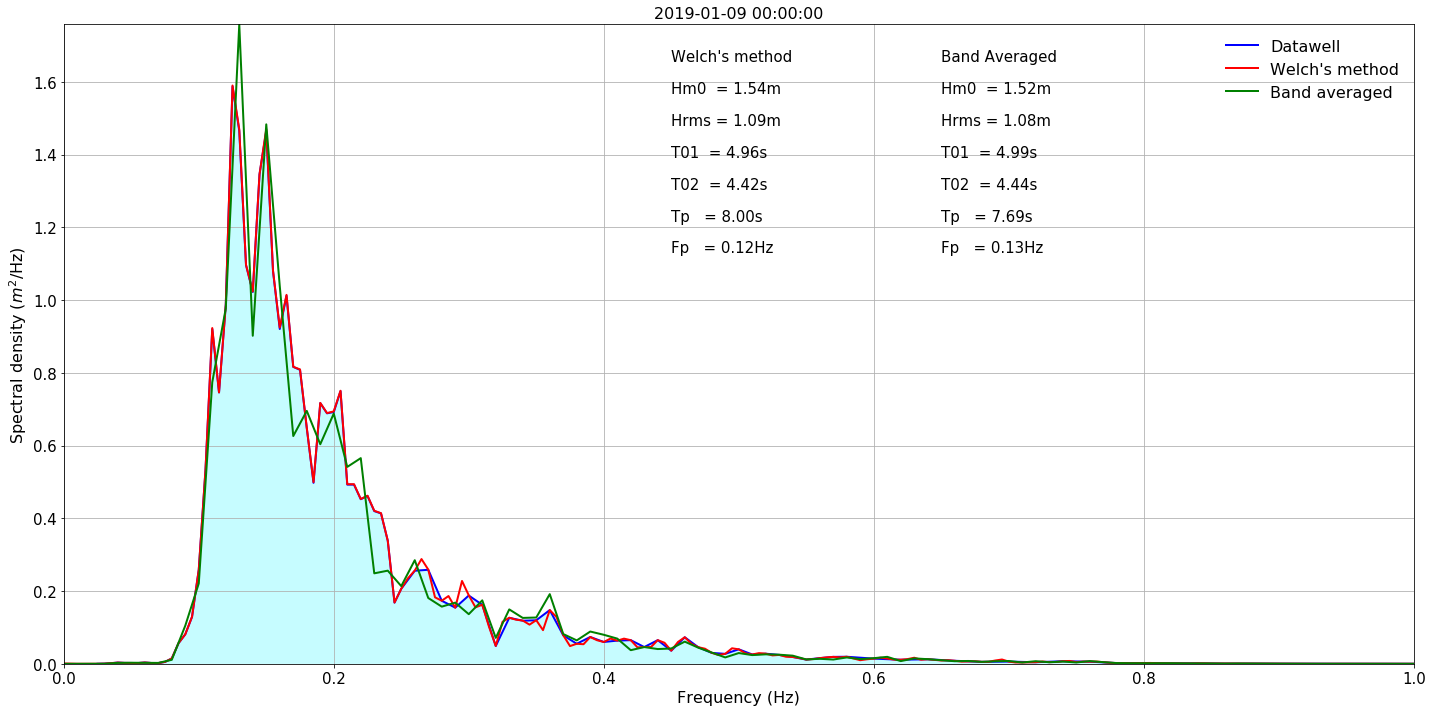

Enter key (or x to Exit) > x


In [20]:
#######################################
#root = Tk() 
##root.filename =  filedialog.askopenfilename(initialdir = "/",title = "Select HVA file",filetypes = (("HVA files","*.HVA"),("all files","*.*")))
#root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data\tweedheads_4225\HVA",title = "Select .HVA",filetypes = (("HVA files","*.HVA"),("all files","*.*")))
#root.destroy()
#Input_HVA_File = root.filename

found = False

while found == False:
    Input_HVA_File = get_file()
    if ((os.path.splitext(Input_HVA_File)[1]).upper() == '.HVA'):
        found = True
    else:
        print('Invalid file format')
    
date_str = Input_HVA_File.split('}')[1].split('.')[0]
Start_time = datetime.strptime(date_str, "%Y-%m-%dT%Hh%MZ")
Next_time = Start_time; F20_time = Start_time; F23_time = datetime.now()

Cycle_counter = []; Displacements_List = []; Packet_List = []

# Open file and read data into separate lists
file = open(Input_HVA_File,"r")
print('Reading ',Input_HVA_File)
for line in file:
    fields = line.split(",")
    Cycle_counter.append(fields[0]); Displacements_List.append(fields[1]); Packet_List.append(fields[2])
file.close()
print('Closing ',Input_HVA_File)

Displacements_List_Old = Displacements_List # Make copy

# Read packet data and convert to actual values
Packet_data = []
for val in Packet_List:
    Packet_data.append(val[1:3])
    Packet_data.append(val[3:5])
    Packet_data.append(val[5:7])
    
Valu_0x7E_List = [i for i, j in enumerate(Packet_data) if j == '7E']
##Valu_0x7D_List = [i for i, j in enumerate(Packet_data) if j == '7D']

# Get the bytes between respective '7E' values - ignoring where consecutive '7E' values exist
fk = []; s_tilde = []; dirn = []; spread = []
for i in range(len(Valu_0x7E_List)-1):
    start = Valu_0x7E_List[i]+1; end = Valu_0x7E_List[i+1]
    if end-start > 1:
        Decoded = Packet_data[start:end]
        
        Found_7D = [m for m, n in enumerate(Decoded) if n == '7D']     # Locate '7D' in packet

        for p in range(len(Found_7D)):
            XOred = hex(int(Decoded[Found_7D[p]+1],16)^int('20',16))   # X'Or the byte after '7D'
            Decoded[Found_7D[p]+1] = XOred[2:].upper()
        for p in range(len(Found_7D)-1,-1,-1): 
            del Decoded[Found_7D[p]]                                   # Remove this '7D' from the packet
            
        Message_Id = Decoded[0][0]+Decoded[1]; 
        CRC_4_Checksum = Decoded[0][1]

        if (Message_Id == 'F20'):
            F20_time,s_tilde,Smax = Do_F20(Decoded)                      # Decode Heave spectrum message
            fk = calc_frequencies()

        if (Message_Id == 'F23'): 
            F23_time,Match_vector,Sample_number,Hn_1_sign,Nn_1_sign,Wn_1_sign,Hn_sign,Nn_sign,Wn_sign = Do_F23(Decoded)          # Decode Spectrum synchronisation message

        if (Message_Id == 'F25'): Do_F25(Decoded)           # Decode Directional Spectral Parameters message
    
        if (F20_time == F23_time):
            if (F20_time >= Next_time):   # Indicates at least one record has been missed
                Position = [i for i, j in zip(count(), Displacements_List_Old) if j == '-'+Match_vector]
                if len(Position) > 0: 
# Get the WL's, and Displacements in North and West
                    Status = []; wls = []; north = []; west = []
                    Get_Displacements(Position,Sample_number, Status, Displacements_List_Old, wls, north, west)
                    Record_time = F20_time  # Pass Record_time to the Calc_parameters cell
                    for j in range(0,Sample_number-1,2):
                        Record_time = Record_time + timedelta(seconds=1/2.56)
                        Next_time = F20_time + timedelta(seconds=4608/2.56)
                        
# calculate frequency values for the Mk4 wave buoy
                    f_Mk4 = []
                    for i in range(0,46,1): f_Mk4.append(0.025+0.005*i)
                    for i in range(46,79,1): f_Mk4.append(-0.20+0.010*i)
                    for i in range(79,100,1): f_Mk4.append(-0.98+0.020*i)  
                    f_avg,Pden_avg,f2,Pden2 = calc_spectral_parameters(wls)
                    Hm0,Hrms,T01,T02,Tp,Fp = get_parameters_Mk4(f_Mk4,s_tilde)
                    Hm0_avg,Hrms_avg,T01_avg,T02_avg,Tp_avg,Fp_avg = get_parameters_Banded(f_avg,Pden_avg)
                    plot_spectra(f_Mk4,s_tilde,f2,Pden2,f_avg,Pden_avg,F20_time,Hm0,Hrms,T01,T02,Tp,Fp,\
                                 Hm0_avg,Hrms_avg,T01_avg,T02_avg,Tp_avg,Fp_avg)
                    
                choice = input("Enter key (or x to Exit) > ")
                if choice == 'x' : break
